## Hierarchical topic regression model

In [2]:
using Distributions, StatsFuns, StatsBase, LogTopReg
import Lazy.@>, Lazy.@>>, Lazy.@as

In [3]:
σ_μ = 0.2;
σ = 0.25;
σ_u = 0.5;
σ_β = 0.5;

n = 250;
p = 3;
nd = repeat([10],inner=[n]);
K = 2;
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
u = randn(K,n)*σ_u;
β = rand(K,p);

X = randn(p,n);
A = rand(InverseWishart(n+1,eye(n)));
A = (A./sqrt(diag(A)))./sqrt(diag(A))';
Z = chol(Hermitian(A));
θ = collect(0:(K-1))*1000;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + u*Z[:,i] + β*X[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> vcat( hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))' ), 1:K)...);
end
Z = convert(Array{Float64,2},Z);

In [13]:
pss = VectorPosterior(PoissonPosterior(0.001,0.001),2);
@time fit = topiclmm(y,X,Z,pss,K,hyperparameter(ν0_σ2η=0.001,σ0_σ2η = 0.001,τ0_u = 0.001,ν0_u=0.001),iter=2000,thin=2);
ns = length(fit[:τ]);

 68.857375 seconds (219.22 M allocations: 59.072 GB, 8.55% gc time)


In [4]:
using Gadfly, DataFrames

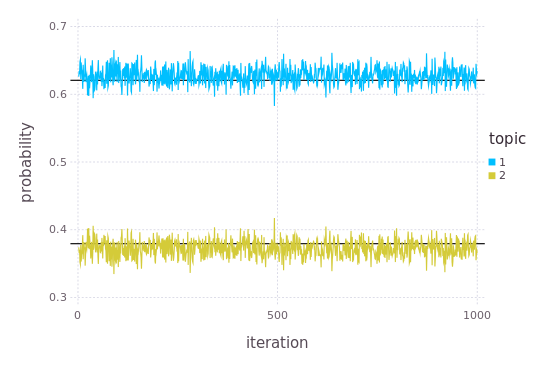

In [14]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=softmax(μ),
Geom.line,Geom.hline(color=colorant"black"))

In [6]:
warmup = 50;

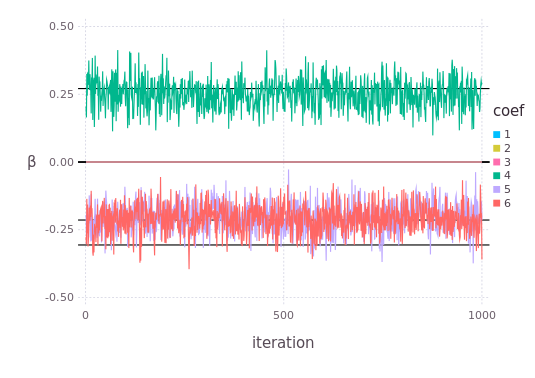

In [15]:
θpost1 = Float64[rand(topicpd(fit[:topic][i,j][1]))[1] for j=(warmup+1):ns, i=1:K];
ord = sortperm(vec(mean(θpost1,1)));
bdat = DataFrame(β = vec( refβ(fit[:β][:,ord,:],fit[:μ][ord,:]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),coef = repeat(map(string,1:(K*p)),outer=[ns]))
plot(bdat,y="β",x="iteration",color="coef",yintercept=vec(refβ(β',μ)),Geom.line,Geom.hline(color=colorant"black"))

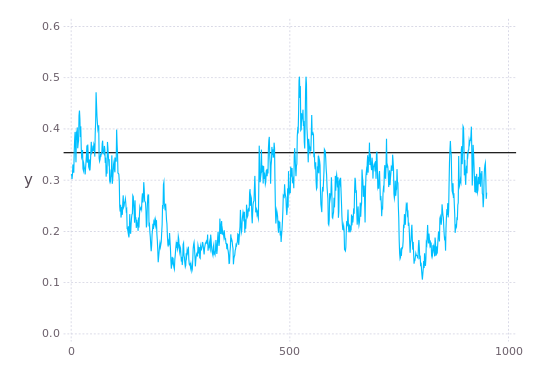

In [20]:
plot(y=sqrt(sum(fit[:σ2],1)[(warmup+1:ns)]),yintercept=[sqrt(σ^2*2)],Geom.line,Geom.hline(color=colorant"black"))

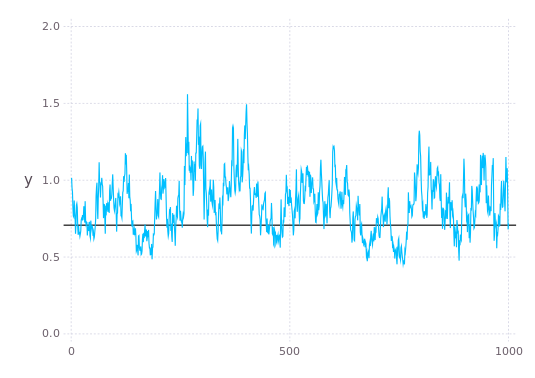

In [21]:
plot(y=sqrt(sum(fit[:σ2] .* fit[:τ_u],1)),yintercept=[sqrt(σ_u^2*2)],Geom.line,Geom.hline(color=colorant"black"))

In [10]:
plot(y=fit[:η][1,:,500]-fit[:η][2,:,500],x=η[1,:]-η[2,:])

LoadError: LoadError: BoundsError: attempt to access 2×250×250 Array{Float64,3} at index [1,Colon(),500]
while loading In[10], in expression starting on line 1

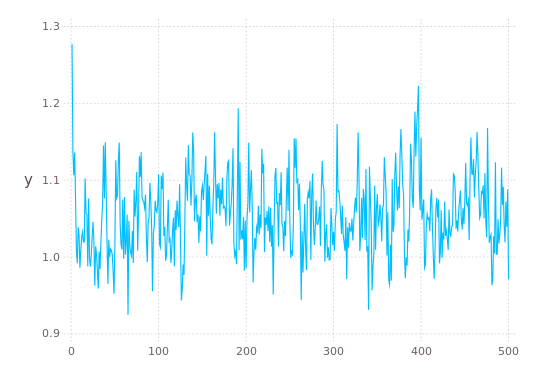

In [13]:
resid = Vector{Float64}(500);
for i in 1:500 resid[i] = std(fit[:η][1,:,i]-fit[:η][2,:,i]-Z'fit[:u][:,1,i]+Z'fit[:u][:,2,i]); end
plot(y=resid,Geom.line)

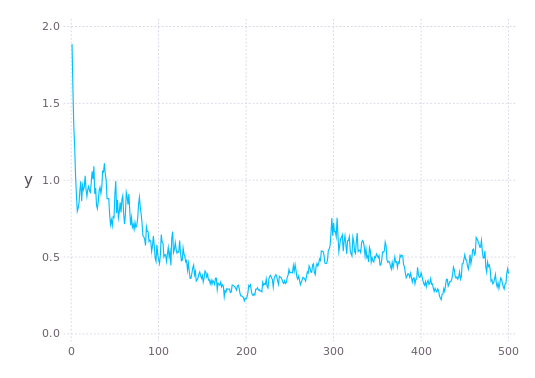

In [14]:
bsig = Vector{Float64}(500);
for i in 1:500 bsig[i] = std(fit[:u][:,1,i]-fit[:u][:,2,i]); end
plot(y=bsig,Geom.line)